<a href="https://colab.research.google.com/github/maxxelbax/ML-Project/blob/main/face_attraction_processing_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis model

In [9]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [11]:
df_data = pd.read_parquet('text_data.parquet.gzip')

X = df_data['text'].tolist()
y = df_data['avg_rating'].tolist()
# y = pd.qcut(df_data['avg_rating'], q=[0, 0.33, 0.66, 1], labels=[0, 1, 2]).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [12]:
train_encodings = tokenizer.batch_encode_plus(X_train, truncation=True, padding=True)
test_encodings = tokenizer.batch_encode_plus(X_test, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [14]:
base = model
model = Sequential()
model.add(base)
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

TypeError: The added layer must be an instance of class Layer. Received: layer=RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): RobertaIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): RobertaOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (classifier): RobertaClassificationHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=768, out_features=28, bias=True)
  )
) of type <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>.

In [8]:
tf.float16
training_args = TFTrainingArguments(
    output_dir='results',
    num_train_epochs=30,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    logging_dir='logs',
    logging_steps=10,
    eval_steps=100
)

with training_args.strategy.scope():
    base_model = TFRobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

"""
model = Sequential(name='test')
model.add(base_model)
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.layers[0].trainable = False
"""

base_model.layers[0].trainable = False
print(base_model.summary())
trainer = TFTrainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 592,899
Non-trainable params: 124,055,040
_________________________________________________________________
None


In [7]:
trainer.train()

InvalidArgumentError: Unable to parse tensor proto

# UNZUPPING THE FILES AND CREATING THE NECESSARY FILE STRUCTURE FOR TRAINING - DO IT ONLY ONCE

In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [24]:
cd ..

/


In [25]:
cd content

/content


In [26]:
cd drive/MyDrive/ML_project/

/content/drive/MyDrive/ML_project


In [27]:
import os
import shutil
import time
import requests

In [28]:
from zipfile import ZipFile

zip_file_path = "hot_or_not_image_and_rating_data.zip"

with ZipFile(zip_file_path, 'r') as zip_file:
    zip_file.extractall()

print("All files extracted.")


All files extracted.


In [29]:
ls

data/    hot_or_not_image_and_rating_data.zip  images_backup/  labels_backup/
female/  images/                               labels/         male/


File processing


In [30]:
# Rename all male files - add 'male' in front
male_folder = "male"

# Ensure the 'male' folder exists
if os.path.exists(male_folder) and os.path.isdir(male_folder):
    for file_name in os.listdir(male_folder):
        file_path = os.path.join(male_folder, file_name)

        # Add "male-" to the file name
        new_file_name = f"male-{file_name}"
        new_file_path = os.path.join(male_folder, new_file_name)

        # Rename the file
        os.rename(file_path, new_file_path)

print("File names in 'male' folder modified.")


File names in 'male' folder modified.


In [31]:
# Rename all female files - add 'female' in front

female_folder = "female"

# Ensure the 'male' folder exists
if os.path.exists(female_folder) and os.path.isdir(female_folder):
    for file_name in os.listdir(female_folder):
        file_path = os.path.join(female_folder, file_name)

        # Add "male-" to the file name
        new_file_name = f"female-{file_name}"
        new_file_path = os.path.join(female_folder, new_file_name)

        # Rename the file
        os.rename(file_path, new_file_path)

print("File names in 'female' folder modified.")


File names in 'female' folder modified.


In [32]:
male_folder = "male"
female_folder = "female"

# Function to delete files based on extension
def delete_non_jpg_txt_files(folder_path):
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is not a '.jpg' or '.txt' file
        if not file_name.lower().endswith(('.jpg', '.txt')):
            # Delete the file if it doesn't have the specified extensions
            os.remove(file_path)

# Delete non '.jpg' and '.txt' files in 'male' folder
if os.path.exists(male_folder) and os.path.isdir(male_folder):
    delete_non_jpg_txt_files(male_folder)

# Delete non '.jpg' and '.txt' files in 'female' folder
if os.path.exists(female_folder) and os.path.isdir(female_folder):
    delete_non_jpg_txt_files(female_folder)

print("Non '.jpg' and '.txt' files deleted in 'male' and 'female' folders.")


Non '.jpg' and '.txt' files deleted in 'male' and 'female' folders.


In [33]:
ls

data/    hot_or_not_image_and_rating_data.zip  images_backup/  labels_backup/
female/  images/                               labels/         male/


In [34]:

# Define folder paths
male_folder = 'male'
female_folder = 'female'

# Function to count items in a folder
def count_items_in_folder(folder):
    if os.path.exists(folder):
        contents = os.listdir(folder)
        num_items = len(contents)
        return num_items
    else:
        return 0

# Count items in 'male' folder
num_items_male = count_items_in_folder(male_folder)

# Count items in 'female' folder
num_items_female = count_items_in_folder(female_folder)

# Display the results
print(f"Number of items in 'male' folder: {num_items_male}")
print(f"Number of items in 'female' folder: {num_items_female}")


Number of items in 'male' folder: 2000
Number of items in 'female' folder: 2000


In [35]:
images_folder = "images"
labels_folder = "labels"
female_folder = "female"
male_folder = "male"

# Create 'images' and 'labels' folders if they don't exist
os.makedirs(images_folder, exist_ok=True)
os.makedirs(labels_folder, exist_ok=True)

print("new folders created")

new folders created


In [36]:
# Function to move files based on extension
def move_files(source_folder, destination_image_folder, destination_labels_folder, valid_image_extensions, valid_text_extensions):
    for file_name in os.listdir(source_folder):
        source_file_path = os.path.join(source_folder, file_name)

        # Check if the file is an image file
        if file_name.lower().endswith(tuple(valid_image_extensions)):
            destination_path = os.path.join(destination_image_folder, file_name)
            shutil.move(source_file_path, destination_path)
        # Check if the file is a text file
        elif file_name.lower().endswith(tuple(valid_text_extensions)):
            destination_path = os.path.join(destination_labels_folder, file_name)
            shutil.move(source_file_path, destination_path)


In [37]:
# Move female files directly to 'images' and 'labels'
move_files(female_folder, images_folder, labels_folder, ('.jpg',), ('.txt'))

# Move male files directly to 'images' and 'labels'
move_files(male_folder, images_folder, labels_folder, ('.jpg',), ('.txt'))

print("Files moved accordingly.")


Files moved accordingly.


In [38]:
# Delete empty 'male' and 'female' folders
try:
    os.rmdir(female_folder)
    print("female folder deleted")
except OSError:
    pass

try:
    os.rmdir(male_folder)
    print("male folder deleted")
except OSError:
    pass



female folder deleted
male folder deleted


In [39]:
# Function to count items in a folder
def count_items(folder_path):
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        return len(os.listdir(folder_path))
    else:
        return 0

# Count items in 'images' folder
num_images = count_items(images_folder)

# Count items in 'labels' folder
num_labels = count_items(labels_folder)

print(f"Number of items in 'images' folder: {num_images}")
print(f"Number of items in 'labels' folder: {num_labels}")

Number of items in 'images' folder: 2000
Number of items in 'labels' folder: 2000


In [40]:
# Function to keep only the first row (score) and delete the rest
def keep_only_score(folder_path):
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is a text file
        if file_name.lower().endswith('.txt'):
            # Read the content of the file
            with open(file_path, 'r', encoding='cp1252') as file:
                lines = file.readlines()

            # Keep only the first line (score) and discard the rest
            if lines:
                score_line = lines[0]
                new_content = [score_line]

                # Write the modified content back to the file
                with open(file_path, 'w') as file:
                    file.writelines(new_content)


In [41]:
# Process text files in 'labels' folder and keep only the score from the first line
keep_only_score(labels_folder)

print("Only the score from the first line kept in all text files in 'labels' folder.")


Only the score from the first line kept in all text files in 'labels' folder.


In [42]:
# Function to count items in a folder
def count_items(folder_path):
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        return len(os.listdir(folder_path))
    else:
        return 0

# Count items in 'images' folder
num_images = count_items('images')

# Count items in 'labels' folder
num_labels = count_items('labels')

print(f"Number of items in 'images' folder: {num_images}")
print(f"Number of items in 'labels' folder: {num_labels}")

Number of items in 'images' folder: 2000
Number of items in 'labels' folder: 2000


**BACKUP ALL DATA**

In [43]:

# Define folder paths
labels_folder = 'labels'
labels_backup_folder = 'labels_backup'

# Function to delete the folder if it exists
def delete_folder(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Deleted existing folder: {folder}")
        time.sleep(1)  # Add a short delay to allow processes to release the folder
    else:
        print(f"Folder does not exist: {folder}")

# Delete existing 'labels_backup' folder
delete_folder(labels_backup_folder)

# Function to copy content from source to destination
def copy_content(source, destination):
    try:
        shutil.copytree(source, destination)
        print(f"Content from '{source}' copied to '{destination}'")
    except Exception as e:
        print(f"Error copying content from '{source}' to '{destination}': {e}")

# Copy the content of 'labels' folder to 'labels_backup'
copy_content(labels_folder, labels_backup_folder)


Deleted existing folder: labels_backup
Content from 'labels' copied to 'labels_backup'


In [44]:


# Define folder paths
images_folder = 'images'
images_backup_folder = 'images_backup'

# Function to delete the folder if it exists
def delete_folder(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Deleted existing folder: {folder}")
        time.sleep(1)  # Add a short delay to allow processes to release the folder
    else:
        print(f"Folder does not exist: {folder}")

# Delete existing 'images_backup' folder
delete_folder(images_backup_folder)

# Function to copy content from source to destination
def copy_content(source, destination):
    try:
        shutil.copytree(source, destination)
        print(f"Content from '{source}' copied to '{destination}'")
    except Exception as e:
        print(f"Error copying content from '{source}' to '{destination}': {e}")

# Copy the content of 'images' folder to 'images_backup'
copy_content(images_folder, images_backup_folder)


Deleted existing folder: images_backup
Content from 'images' copied to 'images_backup'


**counting data**

In [45]:
# Define folder paths
labels_folder = 'labels'
labels_backup_folder = 'labels_backup'
images_folder = 'images'
images_backup_folder = 'images_backup'

# Function to count items in a folder
def count_items_in_folder(folder):
    if os.path.exists(folder):
        contents = os.listdir(folder)
        num_items = len(contents)
        return num_items
    else:
        return 0

# Count items in 'labels' folder
num_items_labels = count_items_in_folder(labels_folder)

# Count items in 'labels_backup' folder
num_items_labels_backup = count_items_in_folder(labels_backup_folder)

# Count items in 'images' folder
num_items_images = count_items_in_folder(images_folder)

# Count items in 'images_backup' folder
num_items_images_backup = count_items_in_folder(images_backup_folder)

# Display the results
print(f"Number of items in 'labels' folder: {num_items_labels}")
print(f"Number of items in 'labels_backup' folder: {num_items_labels_backup}")
print(f"Number of items in 'images' folder: {num_items_images}")
print(f"Number of items in 'images_backup' folder: {num_items_images_backup}")


Number of items in 'labels' folder: 2000
Number of items in 'labels_backup' folder: 2000
Number of items in 'images' folder: 2000
Number of items in 'images_backup' folder: 2000


# let's start the training

Training

In [3]:
!pip install alt-model-checkpoint

In [4]:
import tensorflow
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from alt_model_checkpoint.tensorflow import AltModelCheckpoint
import cv2
import glob
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Model, Input
import os
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [5]:
import seaborn as sns
sns.set_theme()
sns.set_context('paper')
sns.set_style("darkgrid", {'grid.linestyle': '--'})
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.5
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

***CHECKING THE GPU***

In [6]:
# Check if the version is TF 1.x or 2.x
if tf.version.VERSION < '2.0':
    # TF1.X and older
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True
    sess = tf.Session(config=config)
    K.set_session(sess)
else:
    # TF2.X and newer
    if 'COLAB_TPU_ADDR' in os.environ:
        # Using TPU in Colab
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
    else:
        # Non-Colab or local environment
        physical_devices = tf.config.list_physical_devices('CPU')
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)


In [7]:
# Check if TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    # If TPU is not available, check if GPU is available
    if 'COLAB_GPU' in os.environ:
        devices = tf.config.list_logical_devices('GPU')
        if len(devices) > 0 and 'device:GPU:0' in str(devices[0]):
            print("Running on T4 GPU. Number of GPUs: {}".format(len(devices)))
        else:
            print("Running on other GPU. Number of GPUs: {}".format(len(devices)))
    else:
        print("Running on CPU or non-Colab environment")


Running on TPU  ['10.59.43.138:8470']


**Processing images and splitting the data**

In [8]:

def preprocess_image(image, target_size):
    return cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), target_size) / 255.0

def read_label_from_file(label_path):
    try:
        with open(label_path, 'r') as file:
            label = float(file.read().strip())
        return label
    except Exception as e:
        print(f"Error reading label from {label_path}: {e}")
        return None  # You can decide what value to return in case of an error


change directory to content if necessary

In [9]:
cd ..

/


In [10]:
ls

ls: cannot access 'drive': Transport endpoint is not connected
bin@                        datalab/  home/   libx32@                   opt/         run/   tmp/
boot/                       dev/      lib@    media/                    proc/        sbin@  tools/
content/                    drive/    lib32@  mnt/                      python-apt/  srv/   usr/
cuda-keyring_1.0-1_all.deb  etc/      lib64@  NGC-DL-CONTAINER-LICENSE  root/        sys/   var/


In [11]:
cd content

/content


In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/ML_project/

Mounted at /content/drive
/content/drive/MyDrive/ML_project


In [13]:
# Directory
data_dir = 'images'
labels_dir = 'labels'

# Image size
target_size = (224, 224)

# Load images and labels
X = []
y = []

img_files = glob.glob(os.path.join(data_dir, '*.jpg'))

for img_file in tqdm(img_files):
    img_name = os.path.splitext(os.path.basename(img_file))[0]
    img_path = os.path.join(data_dir, img_name + '.jpg')
    label_path = os.path.join(labels_dir, img_name + '.txt')

    # Check if image file can be read
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image from {img_path}")
        continue  # Skip to the next iteration

    # Check if label file can be read
    try:
        label = read_label_from_file(label_path)
    except Exception as e:
        print(f"Error: Could not read label from {label_path}")
        continue  # Skip to the next iteration

    img = preprocess_image(img, target_size)
    X.append(img)
    y.append(label)


  0%|          | 0/2000 [00:00<?, ?it/s]

Error: Could not read image from images/female-0347.jpg
Error: Could not read image from images/female-0912.jpg
Error: Could not read image from images/male-0176.jpg


In [56]:
ls

ls: cannot access 'drive': Transport endpoint is not connected
data/   hot_or_not_image_and_rating_data.zip  images_backup/  labels_backup/
drive/  images/                               labels/         sample_data/


In [104]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1597, 224, 224, 3)
y_train shape: (1597,)
X_val shape: (320, 224, 224, 3)
y_val shape: (320,)
X_test shape: (80, 224, 224, 3)
y_test shape: (80,)


**MODEL**

In [78]:
# Check the shapes

model_name = 'attractiveNet_mnv2'
model_dir = 'models'

model_path= model_dir + '/' + model_name + '.h5'
if not os.path.isdir(model_dir): os.mkdir(model_dir)

In [79]:
basemodel = MobileNetV2(include_top=False, pooling='avg', weights='imagenet')

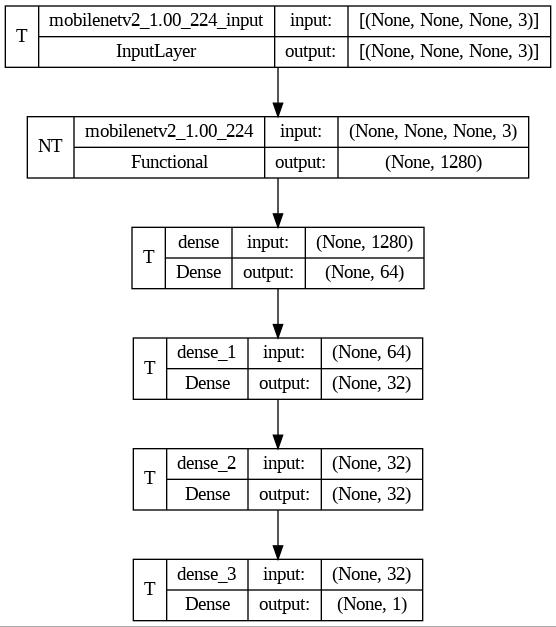

In [181]:
tf.keras.utils.plot_model(model, to_file='test.jpg', show_shapes=True, show_trainable=True)

In [83]:
# basemodel.summary()

In [180]:
model = Sequential(name=model_name)
model.add(basemodel)
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

**training**

In [182]:
# First training with 30 epochs and 0.001 lr
epochs = 30
lr=0.0001

model.layers[0].trainable = False
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
print(model.summary())

Model: "attractiveNet_mnv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,343,137
Trainable params: 85,153
Non-trainable params: 2,257,984
_________________________________

In [184]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-3,
        patience=2,
        verbose=1,
        ),
    AltModelCheckpoint(
        model_path,
        model,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        )
]

In [185]:
import gc

# Perform garbage collection
gc.collect()


118467

In [186]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [187]:
history1 = model.fit(
    X_train,  # Input data
    y_train,  # Target data
    epochs=epochs,
    batch_size=16,  # Specify batch size
    validation_data=(X_val, y_val),  # Validation data
    verbose=1,
    callbacks=callbacks,
)


Epoch 1/30
  6/100 [>.............................] - ETA: 7s - loss: 69.1141

100/100 [==============================] - ETA: 0s - loss: 21.0422
Epoch 1: val_loss improved from inf to 2.95097, saving model to models/attractiveNet_mnv2.h5
100/100 [==============================] - 18s 138ms/step - loss: 21.0422 - val_loss: 2.9510
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 2.8402
Epoch 2: val_loss improved from 2.95097 to 2.55292, saving model to models/attractiveNet_mnv2.h5
100/100 [==============================] - 10s 100ms/step - loss: 2.8402 - val_loss: 2.5529
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 2.4336
Epoch 3: val_loss improved from 2.55292 to 2.33015, saving model to models/attractiveNet_mnv2.h5
100/100 [==============================] - 10s 99ms/step - loss: 2.4336 - val_loss: 2.3302
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 2.1536
Epoch 4: val_loss improved from 2.33015 to 2.18030, saving model to models/attractiveNet_mnv2.h5
100/100 [==============================] -

**Displaying results**

In [189]:

# Assuming you have a folder called 'results' to save your plots
RESULTS_DIR = 'results/'

def plot_metrics(history, model_name, stage):
    # Create a new folder if it doesn't exist
    folder_path = os.path.join(RESULTS_DIR, f'stage_{stage}_{model_name}')
    os.makedirs(folder_path, exist_ok=True)

    f, (ax1) = plt.subplots(1, 1, figsize=(12, 6))
    f.suptitle(f'Stage {stage} Model "{model_name}" training Metrics')

    # Use a log scale on the y-axis
    ax1.semilogy(history.history["loss"], color='darkblue', label="Train")
    ax1.semilogy(history.history["val_loss"], color='darkred', label="Validation")

    ax1.set_title('Loss (Mean Squared Error) over epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()

    # Save the plot in the new folder
    plot_path = os.path.join(folder_path, f'metrics_stage_{stage}_{model_name}.png')
    plt.savefig(plot_path)
    plt.show()

# Example usage:
# Assuming you have a 'history' object from model training
# and model_name, stage are defined



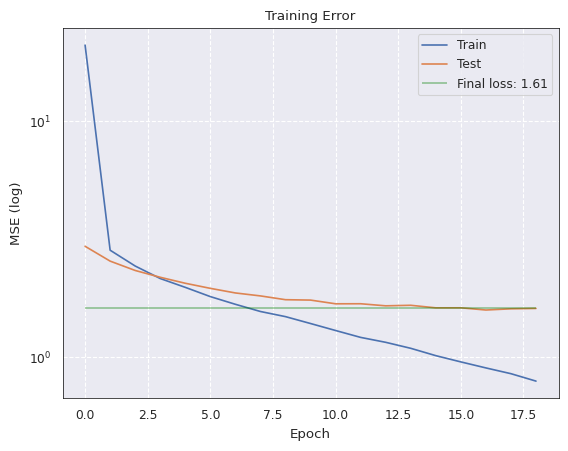

<Figure size 640x480 with 0 Axes>

In [206]:
f_loss = history1.history['val_loss'][-1]
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Test')
plt.hlines(f_loss, xmin=0, xmax=len(history1.history['loss'])-1, alpha=0.4, color='green', label=f'Final loss: {f_loss:.2f}')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE (log)')
plt.title('Training Error')
plt.legend()
plt.show()
plt.savefig('training_error.jpg', )

In [ ]:
# plot_metrics(history1, model_name, 1)

**Testing on some images**

In [169]:
def predict_score(image_path_or_url):
    # Define the model path
    model_path = "models/attractiveNet_mnv2.h5"

    # Check if the input is a web URL or a local file path
    if image_path_or_url.startswith("http"):
        # Load the image from the URL
        response = requests.get(image_path_or_url)
        try:
            img = Image.open(BytesIO(response.content)).convert('RGB')
        except Image.UnidentifiedImageError:
            print("Unable to identify the image file. Please check the URL or try another image.")
            return
    elif os.path.isfile(image_path_or_url):
        # Load the image from the local file path
        try:
            img = Image.open(image_path_or_url).convert('RGB')
        except IOError:
            print("Unable to open the image file. Please check the file path or try another image.")
            return
    else:
        print("Invalid input. Please provide a valid web URL or local file path.")
        return

    # Load the trained model
    loaded_model = load_model(model_path)

    # Make prediction
    prediction = loaded_model.predict(np.array(img).reshape(1, img.size[1], img.size[0], 3) / 255.0)[0][0]
    # print(f'pediction: {prediction}')

    # Display the image with the predicted score
    plt.imshow(img)
    plt.title(f"Beauty Score: {prediction:.2f}")
    plt.axis('off')

    plt.show()

    return prediction


In [170]:
from IPython.display import display, Image as IPImage
import os

def predict_scores_in_folder(folder_path):
    # List all files in the folder
    image_files = os.listdir(folder_path)

    # Filter out non-image files if needed
    image_files = [file for file in image_files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Results dictionary to store predicted scores
    results = {}

    # Loop through each image file and make predictions
    for image_file in image_files:
        # Full path to the image
        image_path = os.path.join(folder_path, image_file)

        # Make prediction and get the score
        predicted_score = predict_score(image_path)

        print(end="  |  ")

        # Store the result in the dictionary
        results[image_file] = predicted_score

    return results

1/1 [==============================] - 1s 926ms/step


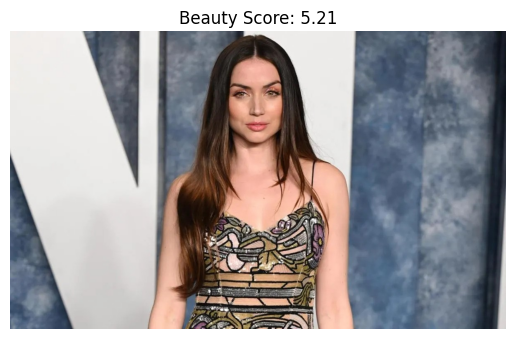

1/1 [==============================] - 1s 981ms/step


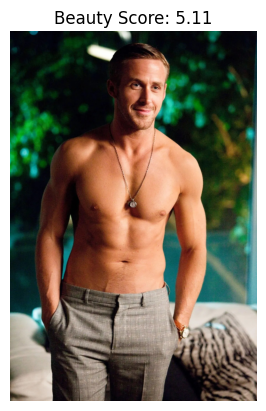

1/1 [==============================] - 1s 843ms/step


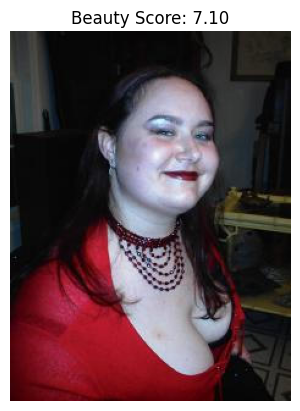

1/1 [==============================] - 1s 850ms/step


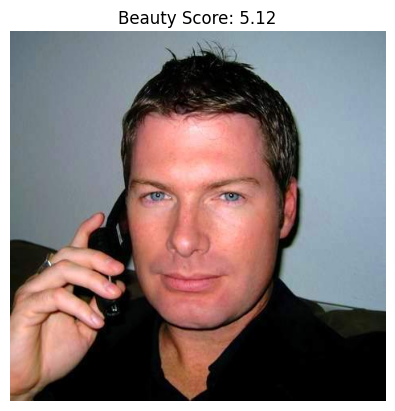

1/1 [==============================] - 1s 935ms/step


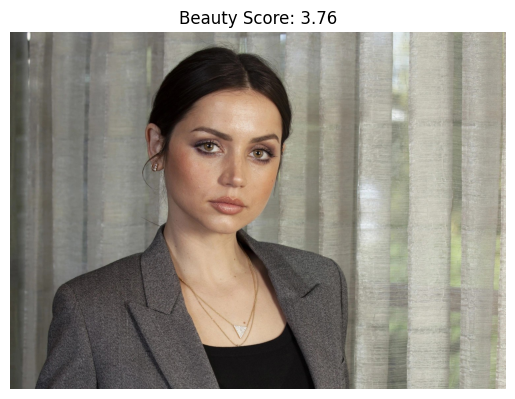

  |  

In [173]:
# Example usage
folder_path = "test_pics"
results = predict_scores_in_folder(folder_path)

Second training

In [ ]:
test_val_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                  )

In [ ]:
batch_size = 16

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

In [ ]:
epochs = 30
lr=0.0001

In [ ]:
model = load_model(model_path)
model.trainable = True
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
print(model.summary())

Model: "attractiveNet_mnv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________
None


In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-3,
        patience=3,
        verbose=1,
        ),
    AltModelCheckpoint(
        model_path,
        model,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        )
]

In [ ]:
history2 = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=len(y_train) // batch_size,
    validation_data=val_generator,
    verbose=1,
    callbacks = callbacks,
)

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 2.1130
Epoch 1: val_loss improved from inf to 1.80442, saving model to models/attractiveNet_mnv2.h5
87/87 [==============================] - 53s 253ms/step - loss: 2.1130 - val_loss: 1.8044
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 1.2059
Epoch 2: val_loss did not improve from 1.80442
87/87 [==============================] - 20s 231ms/step - loss: 1.2059 - val_loss: 3.3098
Epoch 3/30
87/87 [==============================] - ETA: 0s - loss: 1.0359
Epoch 3: val_loss did not improve from 1.80442
87/87 [==============================] - 20s 225ms/step - loss: 1.0359 - val_loss: 5.3782
Epoch 4/30
87/87 [==============================] - ETA: 0s - loss: 0.9121
Epoch 4: val_loss did not improve from 1.80442
87/87 [==============================] - 19s 220ms/step - loss: 0.9121 - val_loss: 10.1414
Epoch 4: early stopping


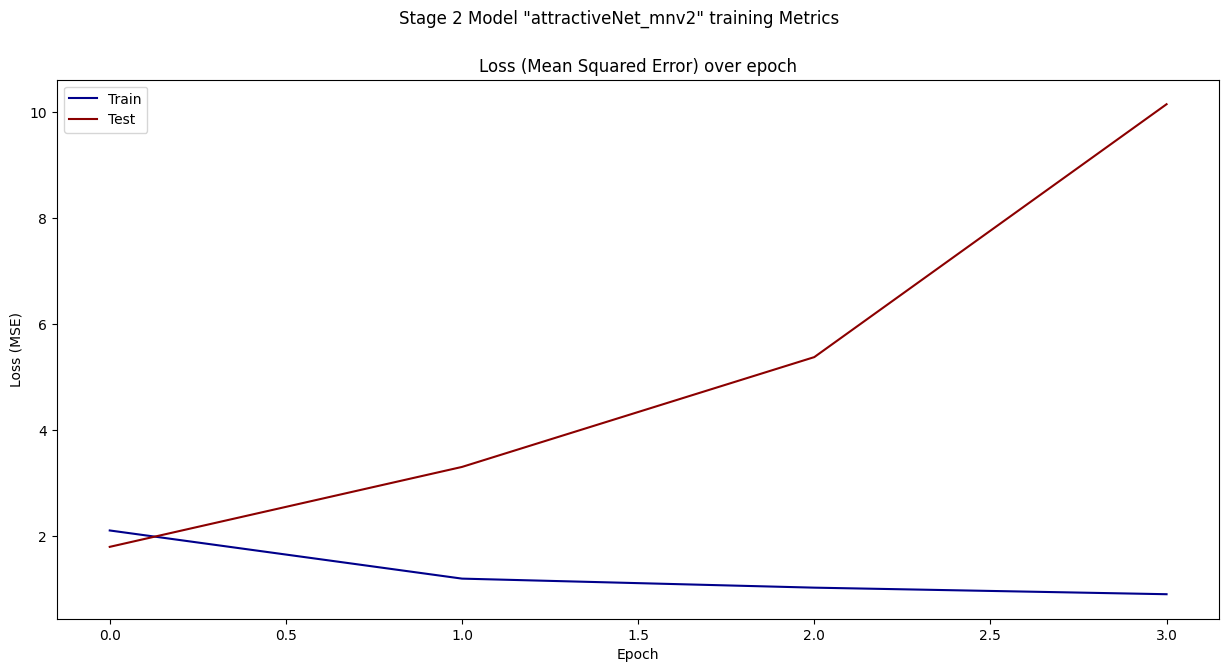

In [ ]:
plot_metrics(history2, model_name, 2)


Third training -- STAGE 3

In [ ]:
# Check the shapes
model_name = 'attractiveNet_mnv2'
model_dir = 'models'

model_path = model_dir + '/' + model_name + '.h5'
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

basemodel = MobileNetV2(include_top=False, pooling='avg', weights='imagenet')

model = Sequential(name=model_name)
model.add(basemodel)
model.add(Dense(1))


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# First training with 30 epochs and 0.0001 learning rate

epochs = 30
lr = 0.0001

model.layers.trainable = False
model.layers[-3:].trainable = True
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
# print(model.summary())

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1,
    ),
    AltModelCheckpoint(
        model_path,
        model,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
    )
]

# Clear previous training history
model.history = None

In [ ]:

history3 = model.fit(
    X_train,  # Input data
    y_train,  # Target data
    epochs=epochs,
    batch_size=16,  # Specify batch size
    validation_data=(X_val, y_val),  # Validation data
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/30
 6/88 [=>............................] - ETA: 9s - loss: 86.9946

87/88 [============================>.] - ETA: 0s - loss: 55.0911
Epoch 1: val_loss improved from inf to 28.15228, saving model to models/attractiveNet_mnv2.h5
88/88 [==============================] - 19s 170ms/step - loss: 54.9829 - val_loss: 28.1523
Epoch 2/30
87/88 [============================>.] - ETA: 0s - loss: 16.8127
Epoch 2: val_loss improved from 28.15228 to 8.04946, saving model to models/attractiveNet_mnv2.h5
88/88 [==============================] - 9s 103ms/step - loss: 16.7708 - val_loss: 8.0495
Epoch 3/30
87/88 [============================>.] - ETA: 0s - loss: 5.7190
Epoch 3: val_loss improved from 8.04946 to 3.66287, saving model to models/attractiveNet_mnv2.h5
88/88 [==============================] - 9s 104ms/step - loss: 5.7040 - val_loss: 3.6629
Epoch 4/30
87/88 [============================>.] - ETA: 0s - loss: 3.5346
Epoch 4: val_loss improved from 3.66287 to 3.05365, saving model to models/attractiveNet_mnv2.h5
88/88 [==============================] - 9s 101ms/st

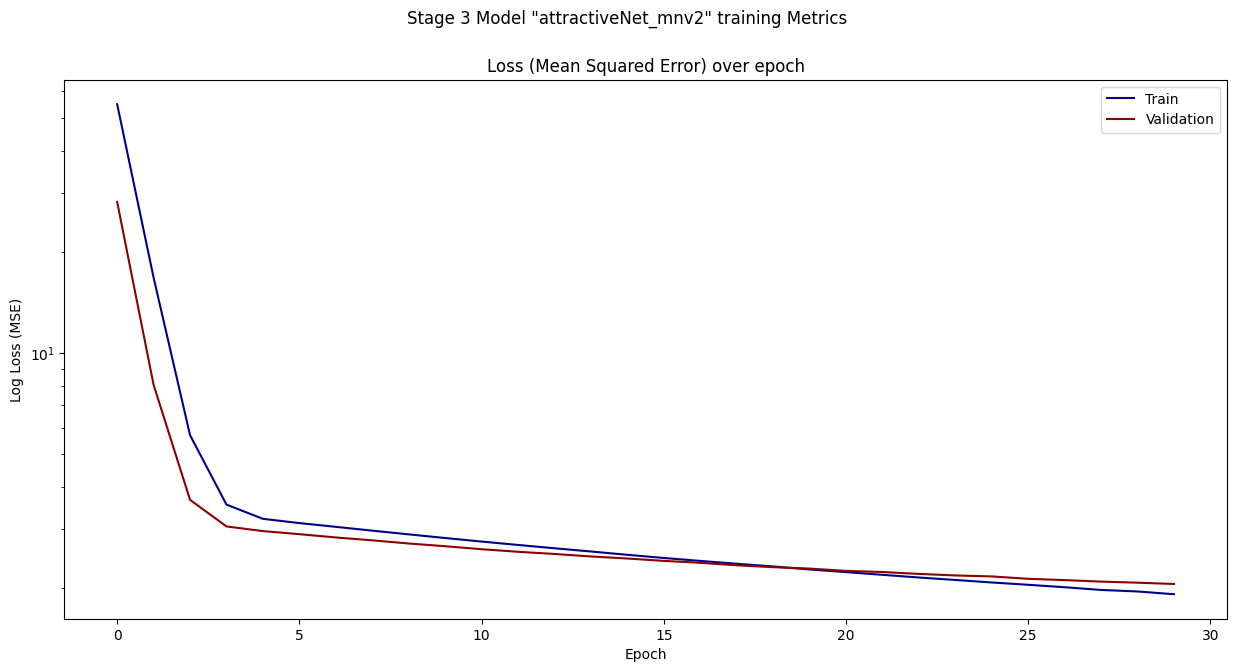

In [ ]:
plot_metrics(history3, model_name, 3)


In [ ]:
def predict_score(image_path_or_url, model_path="models/attractiveNet_mnv2.h5"):
    # Check if the input is a web URL or a local file path
    if os.path.isfile(image_path_or_url):
        # Load the image from the local file path
        try:
            img = Image.open(image_path_or_url).convert('RGB')
        except IOError:
            print("Unable to open the image file. Please check the file path or try another image.")
            return
    else:
        print("Invalid input. Please provide a valid web URL or local file path.")
        return

    # Load the trained model
    loaded_model = load_model(model_path)

    # Make prediction
    prediction = loaded_model.predict(np.array(img).reshape(1, img.size[1], img.size[0], 3) / 255.0)[0][0]

    # Display the image with the predicted score
    plt.imshow(img)
    plt.title(f"Beauty Score: {prediction:.2f}")
    plt.axis('off')

    plt.show()

    return prediction

In [ ]:
from IPython.display import display, Image as IPImage
import os

def predict_scores_in_folder(folder_path):
    # List all files in the folder
    image_files = os.listdir(folder_path)

    # Filter out non-image files if needed
    image_files = [file for file in image_files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Results dictionary to store predicted scores
    results = {}

    # Loop through each image file and make predictions
    for image_file in image_files:
        # Full path to the image
        image_path = os.path.join(folder_path, image_file)

        # Make prediction and get the score
        predicted_score = predict_score(image_path)

        print(end="  |  ")

        # Store the result in the dictionary
        results[image_file] = predicted_score

    return results

1/1 [==============================] - 1s 1s/step


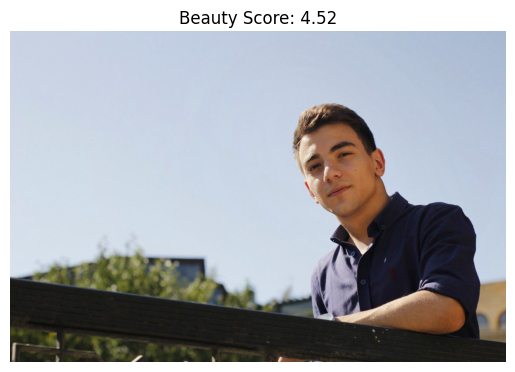

1/1 [==============================] - 1s 918ms/step


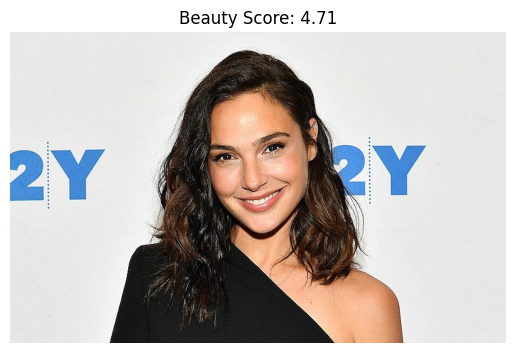

1/1 [==============================] - 1s 924ms/step


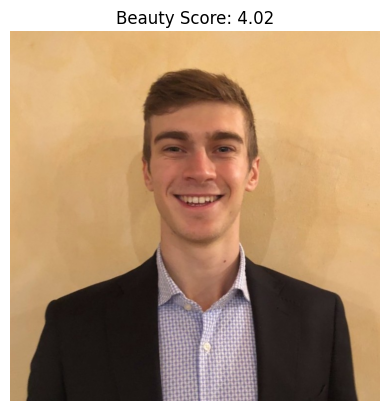

1/1 [==============================] - 1s 1s/step


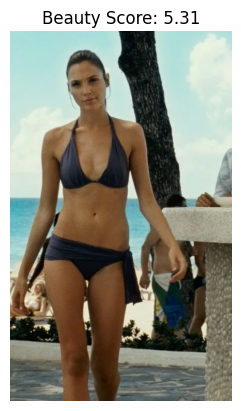

  |  

In [ ]:
# Example usage
folder_path = "test_pics"
results = predict_scores_in_folder(folder_path)
